In [157]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import torchvision.models as models
from sklearn.preprocessing import MultiLabelBinarizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [158]:
metadata_cafe1 = '../nutrition5k_dataset/metadata/dish_metadata_cafe1.csv'

In [159]:
def parse_file(data):
    data = data.split('\n')
    total = 0
    dishes = []
    df_data = []
    print("lines length: ", len(data))
    for line in data:
        line = line.strip()
        if line == '':
            continue
        line = line.split(',')

        num_ingredients = (len(line) - 6) // 7

        new_dish = {
            'dish_id': line[0],
            'total_calories': line[1],
            'total_mass': line[2],
            'total_fat': line[3],
            'total_carbs': line[4],
            'total_protein': line[5],
        }
        dishes.append(line[0])

        total = total + 1
        for i in range(num_ingredients):
            ingredients = line[6+i*7:6+(i+1)*7]
            # print(ingredients)
            ingredient = {
                'ingredient_id': ingredients[0],
                'ingredient_name': ingredients[1],
                'ingredient_mass': float(ingredients[2]),
                'ingredient_calories': float(ingredients[3]),
                'ingredient_fat': float(ingredients[4]),
                'ingredient_carbs': float(ingredients[5]),
                'ingredient_protein': float(ingredients[6])
            }
            df_data.append({**new_dish, **ingredient})
    print("total dishes: ", total)
    return df_data, dishes


def read_and_parse_file(file_path):
    with open(file_path, 'r') as file:
        return parse_file(file.read())


df_data, dishes = read_and_parse_file(metadata_cafe1)
dishes_df = pd.DataFrame(dishes, columns=['dish_id'])

dataset = pd.DataFrame(df_data)

print("unique dishes ids based only on ids from dataset: ",
      dishes_df['dish_id'].unique().shape)
print("unique dishes ids based on all combination ingredient - dish ",
      dataset['dish_id'].unique().shape)

lines length:  4769
total dishes:  4768
unique dishes ids based only on ids from dataset:  (4768,)
unique dishes ids based on all combination ingredient - dish  (4768,)


In [160]:
ingredient_counts = dataset.groupby('ingredient_name')[
    'dish_id'].nunique().sort_values(ascending=False)
ingredient_counts.head(10)

ingredient_name
olive oil      1653
salt           1430
garlic          981
pepper          747
vinegar         737
onions          711
lemon juice     589
broccoli        526
arugula         515
parsley         512
Name: dish_id, dtype: int64

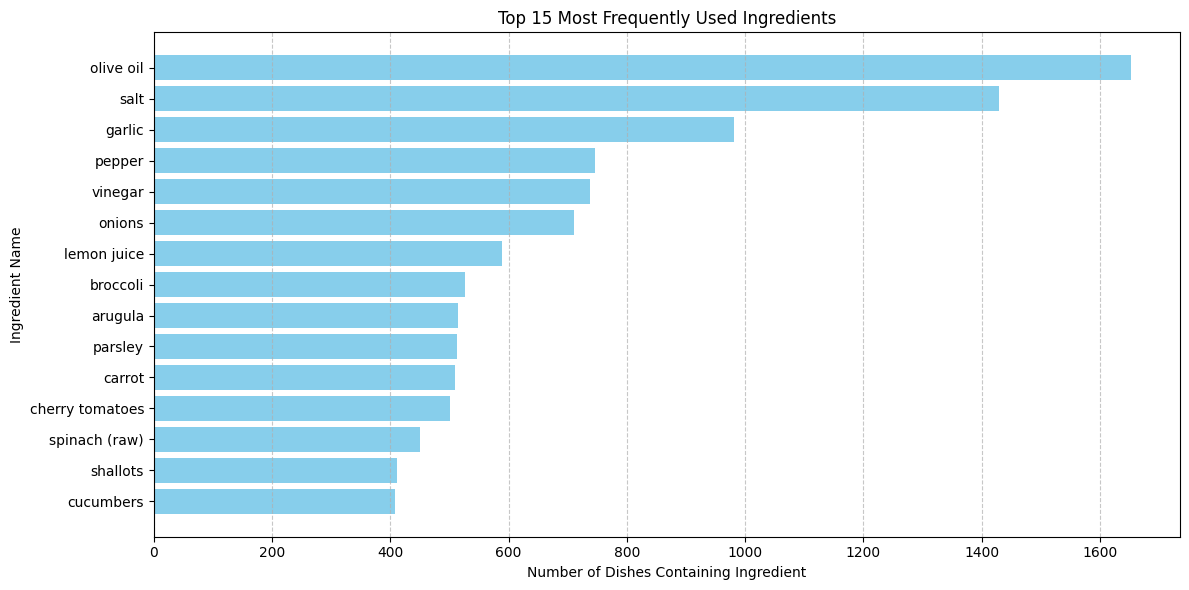

In [161]:
plt.figure(figsize=(12, 6))
top_n = 15

plt.barh(
    # Reverse to show highest at top
    ingredient_counts.head(top_n).index[::-1],
    ingredient_counts.head(top_n).values[::-1],
    color='skyblue'
)

plt.title(f'Top {top_n} Most Frequently Used Ingredients')
plt.xlabel('Number of Dishes Containing Ingredient')
plt.ylabel('Ingredient Name')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [162]:
ingredient_mass = dataset.groupby('ingredient_name')[
    'ingredient_mass'].sum().sort_values(ascending=False)

total_mass = ingredient_mass.sum()

ingredient_mass_pct = (ingredient_mass / total_mass * 100).round(2)

print("Top Ingredients by % Total Mass:")
print(ingredient_mass_pct.head(10))

Top Ingredients by % Total Mass:
ingredient_name
chicken           4.95
egg whites        4.90
olives            3.98
scrambled eggs    3.71
cauliflower       3.10
broccoli          3.05
lemon             2.99
berries           2.58
fish              2.26
apple             2.07
Name: ingredient_mass, dtype: float64


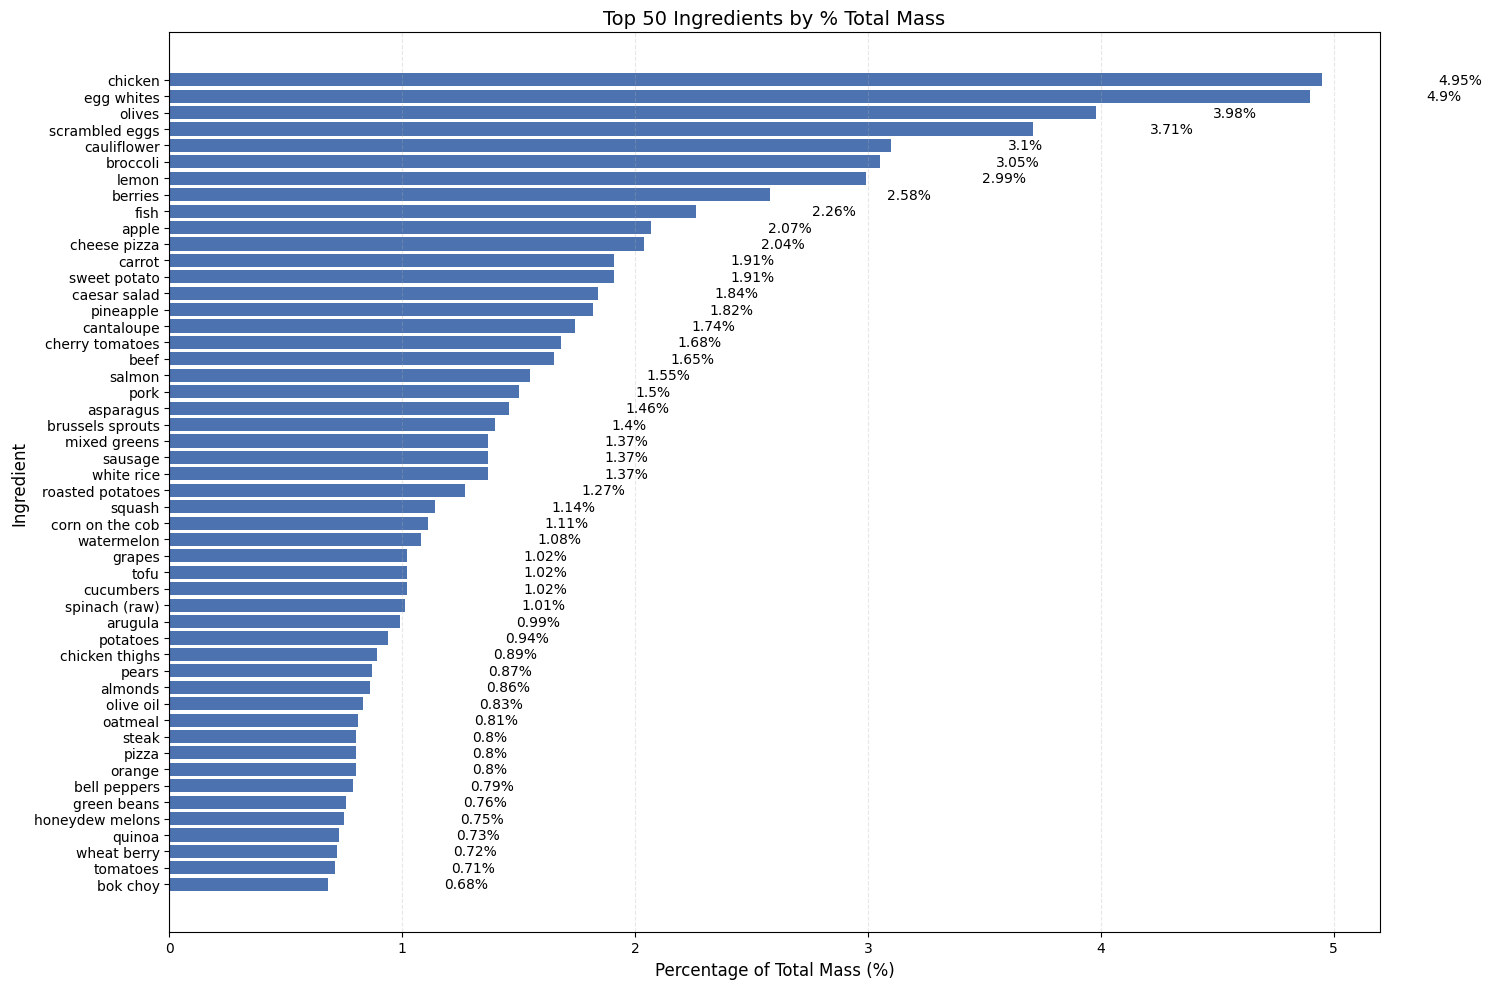

In [163]:

plt.figure(figsize=(15, 10))
top_n = 50  # Show top 15 ingredients

# Select top ingredients and reverse order for plotting
top_ingredients = ingredient_mass_pct.head(top_n).sort_values()

# Plot
plt.barh(
    top_ingredients.index,
    top_ingredients.values,
    color='#4c72b0'  # Customize color
)

# Add labels and title
plt.xlabel('Percentage of Total Mass (%)', fontsize=12)
plt.ylabel('Ingredient', fontsize=12)
plt.title(f'Top {top_n} Ingredients by % Total Mass', fontsize=14)

# Add percentage labels on bars
for i, v in enumerate(top_ingredients.values):
    plt.text(v + 0.5, i, f'{v}%', ha='left', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [164]:
overhead_available_dishes = os.listdir(
    "/home/toni/Documents/nutrition5k/nutrition5k_dataset/imagery/realsense_overhead/")


overhead_available_dishes_df = pd.DataFrame(
    overhead_available_dishes, columns=['dish_id'])

print(overhead_available_dishes_df.shape)
overhead_available_dishes_df.head(10)

(3490, 1)


,dish_id
0,dish_1560442450
1,dish_1562790775
2,dish_1565036890
3,dish_1564761488
4,dish_1565727765
5,dish_1561578623
6,dish_1565207865
7,dish_1559841979
8,dish_1564170098
9,dish_1565809080


In [165]:
top5ingredientsByMass = dataset.sort_values(['dish_id', 'ingredient_mass'], ascending=[
                                            True, False]).groupby('dish_id').head(5).reset_index(drop=True)

labels = top5ingredientsByMass.groupby(
    ['dish_id'])['ingredient_name'].count().reset_index()['ingredient_name']

labels.head(10)

top5ingredientsByMass['labels'] = labels
top5ingredientsByMass.sort_values('labels', ascending=False).head(10)

top5ingredientsByMass = top5ingredientsByMass[top5ingredientsByMass['dish_id'].isin(
    overhead_available_dishes_df['dish_id'])]

top5ingredientsByMass['dish_id'].unique().shape

(3262,)

In [166]:
class DishDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, mlb=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

        if mlb is None:
            self.mlb = MultiLabelBinarizer()
            self.labels = self.mlb.fit_transform(
                dataframe.groupby('dish_id')['ingredient_id']
                .apply(lambda x: list(x.unique()))
            )
        else:
            self.mlb = mlb
            self.labels = self.mlb.transform(
                dataframe.groupby('dish_id')['ingredient_id']
                .apply(lambda x: list(x.unique()))
            )
        self.dish_ids = dataframe['dish_id'].unique()
        self.dish_to_idx = {dish_id: idx for idx,
                            dish_id in enumerate(self.dish_ids)}

    def __len__(self):
        return len(self.dish_ids)

    def __getitem__(self, idx):
        dish_id = self.dish_ids[idx]
        img_path = os.path.join(self.img_dir, f"{dish_id}", "rgb.png")
        image = Image.open(img_path).convert('RGB')

        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

In [167]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    # transforms.RandomResizedCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [168]:
class IngredientClassifier(nn.Module):
    def __init__(self, num_ingredients):
        super().__init__()
        # Use pretrained ResNet50
        self.base_model = models.resnet50(pretrained=True)

        # Freeze base model layers
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Replace final layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_ingredients)
        )

    def forward(self, x):
        return torch.sigmoid(self.base_model(x))

In [169]:
train_dish_ids = pd.read_csv(
    '../nutrition5k_dataset/dish_ids/splits/rgb_train_ids.txt',
    header=None,
    names=['dish_id'])

test_dish_ids = pd.read_csv(
    '../nutrition5k_dataset/dish_ids/splits/rgb_test_ids.txt',
    header=None,
    names=['dish_id'])


train_df = pd.merge(train_dish_ids, top5ingredientsByMass, on='dish_id')

test_df = pd.merge(test_dish_ids, top5ingredientsByMass, on='dish_id')

print("train dataset unique dishes ids: ",
      train_df['dish_id'].unique().shape)
print("test dataset unique dishes ids: ",
      test_df['dish_id'].unique().shape)

train dataset unique dishes ids:  (2755,)
test dataset unique dishes ids:  (507,)


In [170]:

def create_dataloaders(df, train_df, test_df, img_dir, batch_size=32):
    full_dataset = DishDataset(df, img_dir, train_transform)

    mlb = full_dataset.mlb

    train_dataset = DishDataset(
        train_df, img_dir, train_transform, mlb=mlb)
    test_dataset = DishDataset(
        test_df, img_dir, val_transform, mlb=mlb)

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, mlb

In [171]:
def initialize_model(df, device):
    num_ingredients = len(df['ingredient_id'].unique())
    model = IngredientClassifier(num_ingredients)
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    return model.to(device), criterion, optimizer

In [172]:

def train_model(train_loader, val_loader, model, criterion, optimizer, device, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        val_loss = 0.0
        model.eval()

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")

    return model

In [173]:

def start_training():
    global dataset, train_df, test_df
    img_dir = "../nutrition5k_dataset/imagery/realsense_overhead/"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_loader, val_loader, mlb = create_dataloaders(
        dataset, train_df, test_df, img_dir)

    model, criterion, optimizer = initialize_model(dataset, device)

    trained_model = train_model(
        train_loader, val_loader, model, criterion, optimizer, device)

    torch.save(trained_model.state_dict(), "ingredient_classifier.pth")

In [174]:
train_df['ingredient_name'].unique().shape
test_df['ingredient_name'].unique().shape

(123,)

In [175]:
start_training()

/home/toni/Documents/nutrition5k/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/toni/Documents/nutrition5k/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/10
Train Loss: 0.0999 | Val Loss: 0.0692
Exact Match Acc: 0.0004 | Val Exact: 0.0000
Hamming Acc:     0.9752 | Val Hamming: 0.9846

Epoch 2/10
Train Loss: 0.0719 | Val Loss: 0.0685
Exact Match Acc: 0.0000 | Val Exact: 0.0000
Hamming Acc:     0.9838 | Val Hamming: 0.9846

Epoch 3/10
Train Loss: 0.0707 | Val Loss: 0.0680
Exact Match Acc: 0.0000 | Val Exact: 0.0000
Hamming Acc:     0.9838 | Val Hamming: 0.9846

Epoch 4/10
Train Loss: 0.0702 | Val Loss: 0.0680
Exact Match Acc: 0.0000 | Val Exact: 0.0000
Hamming Acc:     0.9838 | Val Hamming: 0.9846

Epoch 5/10
Train Loss: 0.0699 | Val Loss: 0.0681
Exact Match Acc: 0.0000 | Val Exact: 0.0000
Hamming Acc:     0.9838 | Val Hamming: 0.9846

Epoch 6/10
Train Loss: 0.0694 | Val Loss: 0.0682
Exact Match Acc: 0.0000 | Val Exact: 0.0000
Hamming Acc:     0.9838 | Val Hamming: 0.9846

Epoch 7/10
Train Loss: 0.0693 | Val Loss: 0.0678
Exact Match Acc: 0.0000 | Val Exact: 0.0000
Hamming Acc:     0.9838 | Val Hamming: 0.9846

Epoch 8/10
Train Lo